<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/Alesya%20Moroz/Profpatolog_final(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание задачи

Цель проекта:
Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.

Принцип работы:
Система должна помогать врачу вынести решение о том годен, не годен или ограниченно годен человек на определенной должности.
В датасете целевым столбцом для предсказания нейросетью является столбец под названием: “ЗаключениеМК”.

## План проекта


1.   EDA (разведывательный анализ данных)
2.   Парсинг данных
3.   Разработка нейросети





---



# 01_Загрузка библиотек

In [ ]:
%pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 25.9 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential, Model # Полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.metrics import Recall, Precision #, F1Score
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import TextVectorization

import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from pandas.core.common import flatten

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import seaborn as sns

# import autokeras as ak

In [ ]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Mounted at /content/drive


# 02_Анализ исходных данных
В данном разделе проводится анализ и редактирование датасета, предоставленного заказчиком. В рамках данного этапа будут выполнены следующие задачи: поиск пустых строк и пустых столбцов, анализ данных по направлениям исследований, удаление столбцов с ненужной информацией (для поставленной задачи), формирование новых столбцов.

## 02.1_Загрузка датасета

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/датасет профпатолог часть.xlsx')

In [ ]:
df.sample(5) # выводим на экран 5 случайных записей из датасета

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология3_Аудиометрия1_ЗначениеПредставление,Оториноларингология1_ЖалобыДополнение_Значение,Оториноларингология1_ЖалобыДополнение_ЗначениеПредставление,Стоматология2_ВП2_Значение,Стоматология2_ВП2_ЗначениеПредставление,Терапия2_ЗаключениеФОГК_Значение,Терапия2_ЗаключениеФОГК_ЗначениеПредставление,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление
622,9d6f7ba3-5a5b-11ed-8108-0cc47aab8067,1fdc2cd3-424b-11ea-80d8-0cc47aab8067,1982-07-01,Мужской,Мужской,2022-11-02,Периодический,Периодический,False,dc432b14-7559-11e9-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,5c93d167-4f5b-11ed-8107-0cc47aab8067,87a09a3e-ebda-11e8-80ce-0cc47aab8067,1999-06-21,Мужской,Мужской,2022-10-19,Периодический,Периодический,False,f4590331-8ef1-11e7-80db-708bcd7f83cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1169,04dcd620-649b-11ed-8109-0cc47aab8067,cbaf51f9-ee45-11e9-80d1-0cc47aab8067,2000-04-28,Женский,Женский,2022-11-15,Периодический,Периодический,False,dddc70ad-050f-11e8-80c6-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
344,8988c70d-5421-11ed-8108-0cc47aab8067,97186212-9c1b-11e7-80db-708bcd7f83cd,1968-03-29,Мужской,Мужской,2022-10-25,Периодический,Периодический,False,1c392056-5052-11ed-8107-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
492,dbcb7699-58dd-11ed-8108-0cc47aab8067,41680046-da19-11eb-80f6-0cc47aab8067,1990-09-27,Мужской,Мужской,2022-10-31,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 4587 entries, ДокументПрохождениеМедосмотра to Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление
dtypes: bool(1), datetime64[ns](43), float64(1253), object(3290)
memory usage: 69.3+ MB


В датасете существуют следующие типы данных:
 - bool(1)
 - datetime64(43)
 - float64(1253)
 - object(3290)

In [ ]:
#@title Размерность исходного датасета
print('Количество строк:   ', df.shape[0])
print('Количество столбцов:', df.shape[1])

Количество строк:    1982
Количество столбцов: 4587


## 02.2_Редактирование датасета

In [ ]:
#@title Проверка наличия пропусков по столбцу 'Клиент'
if df['Клиент'].isna().sum() > 0:
    print('Количество строк с пропусками:', df['Клиент'].isna().sum())
    df = df.dropna(subset=['Клиент'])
    print('Удалены строки с пустыми значениями в столбце "Клиент"')
else:
    print('Количество строк с пропусками:', df['Клиент'].isna().sum())

Количество строк с пропусками: 0


### Корректировка данных по целевому столбцу 'ЗаключениеМК'
1. Удаление строк со значениями "nan"
2. Удаление строк с нерелевантной информацией (при наличии)

In [ ]:
print('Количество строк с пропусками в столбце "ЗаключениеМК":             ', df['ЗаключениеМК'].isna().sum())
print('Количество строк с пропусками в столбце "ЗаключениеМКПредставление":', df['ЗаключениеМКПредставление'].isna().sum())
print('Количество строк с пропусками в столбце "Заключение":               ', df['Заключение'].isna().sum())
# df[pd.isna(df['ЗаключениеМК'])]['ЗаключениеМК']

Количество строк с пропусками в столбце "ЗаключениеМК":              407
Количество строк с пропусками в столбце "ЗаключениеМКПредставление": 407
Количество строк с пропусками в столбце "Заключение":                419


In [ ]:
# проверяем релевантность значений в столбце "ЗаключениеМК"

print(df['ЗаключениеМК'].value_counts())

Годен                               1434
ГоденСКоррекциейЗрения               123
ВременноНегоден                        9
НуждаетсяВДообследованииИЛечении       2
ОграниченноГоден                       2
Газоспасатель                          2
ГоденБезРаботНаВысотах                 1
машинист бульдозера                    1
 Газоспасатель                         1
Name: ЗаключениеМК, dtype: int64


видим нерелевантные значения в столбце 'ЗаключениеМК': 'машинист бульдозера' 'Газоспасатель' ' Газоспасатель'

In [ ]:
# функция для удаления строки со значением nan и нерелевантными значениями

def clean_column(dataframe, name_series, irrelevant_values):
    df_cleaned = dataframe.dropna(subset=[name_series])

    for i in irrelevant_values:
        df_cleaned = df_cleaned.loc[df[name_series] != i]

    return df_cleaned

In [ ]:
irrelevant_values = ['машинист бульдозера', 'Газоспасатель', ' Газоспасатель']
name_series = 'ЗаключениеМК'
df_01 = clean_column(df,name_series, irrelevant_values)

In [ ]:
print(df_01['ЗаключениеМК'].value_counts())

Годен                               1434
ГоденСКоррекциейЗрения               123
ВременноНегоден                        9
НуждаетсяВДообследованииИЛечении       2
ОграниченноГоден                       2
ГоденБезРаботНаВысотах                 1
Name: ЗаключениеМК, dtype: int64


### Удаление столбцов

In [ ]:
#@title  с дублирующей информацией
# столбцы 'ЗаключениеМКПредставление', 'Заключение' удаляем из датасета, как дублирующие

df_01 = df_01.drop(['ЗаключениеМКПредставление', 'Заключение'], axis='columns')

In [ ]:
#@title  с нулевыми значениями

df_02 = df_01.dropna(axis='columns',how='all')

In [ ]:
print('df_01: ', df_01.shape)
print('df_02: ', df_02.shape)
print('удалено пустых столбцов:', df_01.shape[1] - df_02.shape[1] )

df_01:  (1571, 4585)
df_02:  (1571, 3576)
удалено пустых столбцов: 1009


In [ ]:
#@title  с нерелевантной информацией

keywords_to_drop = 'ДатаПриема|_Дата|Документ|Салон|Специализация|Врач'
columns_to_drop = list(df_02.filter(regex=keywords_to_drop).columns)
df_03 = df_02.drop(columns_to_drop, axis='columns')

# print('df_02: ', df_02.shape)
# print('df_03: ', df_03.shape)
print('столбцов к удалению:',len(columns_to_drop))
print('удалено столбцов:   ', df_02.shape[1] - df_03.shape[1] )

столбцов к удалению: 381
удалено столбцов:    381


### Фильтрация столбцов для финального датасета

В данной части будут отфильтрованы столбцы для дальнейшего использования в части формирования обучающих и тестовых данных. В датасет будут включены столбцы отвечающие следующим требованиям:
1. Столбцы с общей информацией
2. Столбцы с признаком "Представление"
3. Столбцы с признаком

In [ ]:
#@title  Столбцы с общей информацией

columns_general = ['КлиентДатаРождения',
                   'КлиентПолПредставление',
                   'ДатаЗавершенияМедосмотра',
                   'ДиспансернаяГруппаПредставление',
                   'Профессия',
                   'ВредныеФакторы',
                   'ЗаключениеМК']

print('Количество столбцов с общей информацией:', len(columns_general ))

Количество столбцов с общей информацией: 7


In [ ]:
#@title  Столбцы с признаком "Представление" + "Профнепригодность"
# столбцы с признаком "Представление" содержат дублирующую или обобщенную информацию со столбцами аналогичного наименования
# столбцы с признаком "Профнепригодность" содержат информацию годен/негоден по профильным специалистам

keywords_unsuitability = 'Профнепригодность'
df_04 = df_03.filter(regex=keywords_unsuitability)

keywords_representation = 'Представление'
columns_representation = list(df_04.filter(regex=keywords_representation).columns)[3:]

print('Количество столбцов с признаком "Представление":', len(columns_representation))
print()
columns_representation[:5]

Количество столбцов с признаком "Представление": 76



['ХирургНеИсп1_ПрофнепригодностьВременнаяПредставление1',
 'Гинекология1_ПрофнепригодностьВременнаяПредставление1',
 'Стоматология1_ПрофнепригодностьВременнаяПредставление1',
 'Дерматовенерология1_ПрофнепригодностьВременнаяПредставление1',
 'Рентгенология1_ПрофнепригодностьВременнаяПредставление1']

In [ ]:
#@title  Столбцы с признаком "МКБ"
# Столбцы с признаком "МКБ" содержат основную информацию о поставленных диагнозах в разрезе профильных специалистов

keywords_mkb = 'МКБ'
columns_mkb = list(df_03.filter(regex=keywords_mkb).columns)

print('Количество столбцов с признаком "МКБ":', len(columns_mkb))
print()
columns_mkb[:5]

Количество столбцов с признаком "МКБ": 91



['ПсихиатрияНаркология1_МКБ101',
 'Офтальмология1_МКБ101',
 'Оториноларингология1_МКБ101',
 'ХирургНеИсп1_МКБ101',
 'Гинекология1_МКБ101']

In [ ]:
# Объединение отфильтрованных столбцов

columns_final = columns_general + columns_representation + columns_mkb
print('Количество столбцов для финального датасета:', len(columns_final))

Количество столбцов для финального датасета: 174


In [ ]:
df_final = df_03[columns_final]
df_final.reset_index(drop= True , inplace= True) # сбрасываем индексацию строк
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Columns: 174 entries, КлиентДатаРождения to Оториноларингология3_МКБ101
dtypes: datetime64[ns](2), object(172)
memory usage: 2.1+ MB


## 02.3_Подготовка данных по заключениям в разрезе профильных специалистов (Годен - не годен)
цель - получение вектора длиной равной количеству профильных специалистов (по текущему датасету 19)

In [ ]:
#@title Определение направлений исследований (по столбцам)
columns = df_03.columns
col_specialization = []
for i, column in enumerate(columns):
    string = re.split('_|[0-9]', column)
    if len(string) > 1:
        if string[0] not in col_specialization:
            col_specialization.append(string[0])
            print(len(col_specialization), string[0])

1 ЛабораторныеИсследования
2 Рентгенология
3 ПсихиатрияНаркология
4 Офтальмология
5 Оториноларингология
6 ХирургНеИсп
7 Гинекология
8 ФункциональнаяДиагностика
9 Стоматология
10 Эндоскопия
11 Терапия
12 Дерматовенерология
13 Неврология
14 УЗИДиагностика
15 Хирургия
16 ЭКГНеИсп
17 ПроцедурнаяМедсестра
18 Психиатрия
19 ТерапевтНеИсп


In [ ]:
data = df_final.filter(regex=col_specialization[1])
data.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Data columns (total 8 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   Рентгенология1_ПрофнепригодностьВременнаяПредставление1  70 non-null     object
 1   Рентгенология2_ПрофнепригодностьВременнаяПредставление1  3 non-null      object
 2   Рентгенология1_ПрофнепригодностьВременнаяПредставление2  2 non-null      object
 3   Рентгенология2_ПрофнепригодностьВременнаяПредставление2  2 non-null      object
 4   Рентгенология1_МКБ101                                    71 non-null     object
 5   Рентгенология2_МКБ101                                    3 non-null      object
 6   Рентгенология1_МКБ102                                    2 non-null      object
 7   Рентгенология2_МКБ102                                    2 non-null      object
dtypes: object(8)
memory usage: 98.3+ KB


In [ ]:
#@title Функция объединения столбцов с заключениями проф специалистов и очистки данных

def merge_columns(df, columns, series_name):

    df[columns] = df[columns].fillna('')
    df[series_name] = df[columns].astype(str).agg((lambda x: ','.join(x.unique())), axis= 1 )
    values_list = df[series_name].to_list()
    # print(values_list)

    # очищаем данные
    merge_list =[]
    for a in values_list :
        if a == '':
            b = 'Не определено'
        else:
            b = re.sub(r',\s*(?=,|$)', '', a).strip(',')

        merge_list.append(b)
        # print(b

    df[series_name] = True
    df[series_name] = merge_list

    # print(df[series_name].unique())
    # print(type(df[series_name]))
    # print(df[series_name].dtypes)

    return df[series_name]

Так как столбцов с признаком "Профнепригодность" несколько, во избежание потери информации проведем соединение информации в колонках со следующими допущениями: при наличии в столбцах заключений проф. специалистов варианта "не годен" берется именно этот вариант

In [ ]:
#@title Функция, определяющая заключение профильного специалиста
# со следующими допущениями: при наличии в столбцах заключений проф. специалистов варианта "не годен" берется именно этот вариант

def spec_colnclusion(arg):

    classes = ['годен', 'ограниченно годен', 'не годен', 'не определено']
    limited_eff = ['ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'ОграниченноГоден', 'Годен, кроме п.']

    if arg == 'Годен':
        y = classes[0]
    elif arg == 'Не определено':
        y = classes[3]
    elif arg in limited_eff:
        y = classes[1]
    else:
        y = classes[2]

    return  y

In [ ]:
# разделение заключений
def split(arg):
    splitted = re.split(r',', arg)
    return splitted

In [ ]:
#@title  Формирование объединенного столбца с заключениями профильных специалистов

# на выходе необходимо получить столбцы с любым из параметров : Годен, Негоден, Ограниченно годен, Не определено
# из датафрейма выделяем  колонки, которые необходимо объединить

j = 1
columns_merged = []
for i in col_specialization:
    filter_1 = i
    filter_2 = 'Профнепригодность'

    data_to_merge = df_final.filter(regex=filter_1).filter(regex=filter_2)
    # print(data_to_merge.columns)

    df_modified = df_final
    columns = data_to_merge.columns
    series_name = 'spec_conclusion_%03d' % j
    j += 1
    merge_columns(df_modified, columns, series_name=series_name)
    columns_merged.append(series_name)

for i in columns_merged:
    df_modified[i] = df_modified[i].apply(spec_colnclusion)

df_modified['spec_conclusions'] = df_modified[columns_merged].astype(str).agg(','. join , axis= 1 )
df_modified['spec_conclusions'] = df_modified['spec_conclusions'].apply(split)

In [ ]:
# теперь в столбце содержится вектор из 19 элементов, содержащий заключения профильных специалистов.

df_modified['spec_conclusions'][10]

['не определено',
 'не определено',
 'не определено',
 'не определено',
 'не определено',
 'не определено',
 'не определено',
 'не определено',
 'годен',
 'не определено',
 'годен',
 'не определено',
 'годен',
 'не определено',
 'годен',
 'не определено',
 'не определено',
 'не определено',
 'не определено']

## 02.4_Подготовка данных по заключениям в разрезе профильных специалистов (МКБ)

In [ ]:
# столбцы с признаком "МКБ"

print('Пример столбцов с признаком "МКБ":', columns_mkb[:5], '\n')
print('Количество столбцов с признаком "МКБ":', len(columns_mkb))

Пример столбцов с признаком "МКБ": ['ПсихиатрияНаркология1_МКБ101', 'Офтальмология1_МКБ101', 'Оториноларингология1_МКБ101', 'ХирургНеИсп1_МКБ101', 'Гинекология1_МКБ101'] 

Количество столбцов с признаком "МКБ": 91


In [ ]:
#@title Объединение МКБ столбцов
# Столбцы с признаком "МКБ" объединяем

df_modified['mkb_all'] = df_modified[columns_mkb].astype(str).agg(','. join , axis= 1 )
print('Объединенные данные: ', df_modified['mkb_all'][5])

Объединенные данные:  nan,H52.2,Z00.0,nan,nan,Z00.0,nan,nan,Z00.0,Z00.0,Z00.0,H53.0,Z00.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
#@title Функция разделения элементов и очистки от nan и дубликатов
# очищаем данные от nan и дубликатов

def mkb_all(arg):
    new = re.split(r',', arg)
    unique = list(set(new))
    unique.remove('nan')
    return unique

In [ ]:
df_modified['mkb_all_unique'] = df_modified['mkb_all'].apply(mkb_all)
print('Очищенные данные: ', df_modified['mkb_all_unique'][5])

Очищенные данные:  ['H52.2', 'Z00.0', 'H53.0']


# 03_Формирование справочников
Для универсальности используем токенайзер, во избежание переписывания функций при изменении входных данных (например добавлении или удалении каких-либо параметров)

In [ ]:
#@title Справочник 'КлиентПолПредставление'

vocabulary_sex = list(df_modified['КлиентПолПредставление'].astype(str).unique())
try:
    vocabulary_sex.remove('nan')
except:
    pass
print(vocabulary_sex)

['Женский', 'Мужской']


In [ ]:
#@title Справочник 'ДиспансернаяГруппаПредставление'

vocabulary_dispensary = list(df_modified['ДиспансернаяГруппаПредставление'].astype(str).unique())
try:
    vocabulary_dispensary.remove('nan')
except:
    pass
print(vocabulary_dispensary)

['I', 'IIIа', 'II', 'IIIб']


In [ ]:
#@title Справочник заключений профильных специалистов Годен/НеГоден

vocabulary_conclusion = ['годен', 'ограниченно годен', 'не годен', 'не определено']
print(vocabulary_conclusion )

['годен', 'ограниченно годен', 'не годен', 'не определено']


In [ ]:
#@title Справочник 'ВредныеФакторы'
# В данном ноутбуке справочник 'ВредныеФакторы' формируется на основе нормативной документации.
# Далее можно использовать справочник, который используется в клинике.

df_factors = pd.read_csv('/content/drive/MyDrive/NU_files/стажировка/Вредные факторы_справочник - Лист1 - Вредные факторы_справочник - Лист1.csv')
df_factors.info()

print('---')
print('\nПример записей в справочнике:')
print(df_factors['1'][:3])

# Из справочника нам необходимы только цифровые коды


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   1       230 non-null    object
dtypes: object(1)
memory usage: 1.9+ KB
---

Пример записей в справочнике:
0    1.1. Азота неорганические соединения (в том чи...
1    1.2. Азотсодержащие органические соединения (в...
2    1.3. Альдегиды алифатические (предельные и неп...
Name: 1, dtype: object


In [ ]:
# функция для выделения цифрового кода

def factors_find(arg):
    # string = df_factors['1'][200]
    factors = re.split(r' ', arg)

    return factors[0][:][:-1]

In [ ]:
df_factors['digital_code'] = df_factors['1'].apply(factors_find)
print('Пример цифровых кодов:')
print(df_factors['digital_code'][:5])

Пример цифровых кодов:
0    1.1
1    1.2
2    1.3
3    1.4
4    1.5
Name: digital_code, dtype: object


In [ ]:
# Формирование справочника цифровых кодов:

vocabulary_hfactor = df_factors['digital_code'].to_list()
print(vocabulary_hfactor[:10], '\n')
print('Длина справочника ВредныеФакторы: ',len(vocabulary_hfactor))

['1.1', '1.2', '1.3', '1.4', '1.5', '1.5.1', '1.6', '1.7', '1.7.1', '1.7.2'] 

Длина справочника ВредныеФакторы:  230


In [ ]:
#@title Справочник 'МКБ'
# В данном ноутбуке справочник 'МКБ' формируется на основе нормативной документации.
# Далее можно использовать справочник, который используется в клинике.

df_mkb_catalog = pd.read_excel('/content/drive/MyDrive/NU_files/стажировка/spr_mkb10.xls')
df_mkb_catalog.info()

print('---')
print('\nПример записей в справочнике:')
print(df_mkb_catalog['mkb_cod'][:5])

# Из справочника нам необходимы цифровые коды столбец 'mkb_cod'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12941 entries, 0 to 12940
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mkb_cod   12941 non-null  object
 1   mkb_name  12941 non-null  object
 2   class_id  12941 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 303.4+ KB
---

Пример записей в справочнике:
0      A00
1    A00.0
2    A00.1
3    A00.9
4      A01
Name: mkb_cod, dtype: object


In [ ]:
vocabulary_mkb = df_mkb_catalog['mkb_cod'].to_list()
print(vocabulary_mkb[:10], '\n')
print('Длина справочника МКБ: ',len(vocabulary_mkb))

['A00', 'A00.0', 'A00.1', 'A00.9', 'A01', 'A01.0', 'A01.1', 'A01.2', 'A01.3', 'A01.4'] 

Длина справочника МКБ:  12941


In [ ]:
#@title Объединенный справочник для векторизации

vocabulary = vocabulary_sex + vocabulary_dispensary + vocabulary_conclusion + vocabulary_hfactor + vocabulary_mkb

print(vocabulary[:13])
print(vocabulary[235:245])
print('\nДлина общего справочника: ',len(vocabulary))

['Женский', 'Мужской', 'I', 'IIIа', 'II', 'IIIб', 'годен', 'ограниченно годен', 'не годен', 'не определено', '1.1', '1.2', '1.3']
['23', '24', '25', '26', '27', 'A00', 'A00.0', 'A00.1', 'A00.9', 'A01']

Длина общего справочника:  13181


# 04_Tokenizer

In [ ]:
#@title Определение токенайзера

max_tokens = len(vocabulary)+1
tokenizer = Tokenizer(num_words=max_tokens,
                             filters='!"#$%&()*+-–—/…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                             lower=False,
                             split=',',
                             oov_token='unknown',
                             char_level=False)


tokenizer.fit_on_texts(vocabulary)

In [ ]:
print(tokenizer.word_index)

{'unknown': 1, 'Женский': 2, 'Мужской': 3, 'I': 4, 'IIIа': 5, 'II': 6, 'IIIб': 7, 'годен': 8, 'ограниченно годен': 9, 'не годен': 10, 'не определено': 11, '1.1': 12, '1.2': 13, '1.3': 14, '1.4': 15, '1.5': 16, '1.5.1': 17, '1.6': 18, '1.7': 19, '1.7.1': 20, '1.7.2': 21, '1.8': 22, '1.8.1': 23, '1.8.1.1': 24, '1.8.1.2': 25, '1.8.2': 26, '1.8.2.1': 27, '1.8.2.2': 28, '1.8.3': 29, '1.8.3.1': 30, '1.8.3.2': 31, '1.8.4': 32, '1.8.4.1': 33, '1.8.4.2': 34, '1.9': 35, '1.10': 36, '1.11': 37, '1.12': 38, '1.13': 39, '1.14': 40, '1.14.1': 41, '1.14.2': 42, '1.15': 43, '1.15.1': 44, '1.16': 45, '1.17': 46, '1.18': 47, '1.18.1': 48, '1.18.2': 49, '1.18.3': 50, '1.19': 51, '1.19.1': 52, '1.19.2': 53, '1.19.3': 54, '1.20': 55, '1.21': 56, '1.22': 57, '1.23': 58, '1.24': 59, '1.25': 60, '1.26': 61, '1.27': 62, '1.27.1': 63, '1.27.2': 64, '1.28': 65, '1.29': 66, '1.29.1': 67, '1.29.2': 68, '1.29.3': 69, '1.29.4': 70, '1.29.5': 71, '1.30': 72, '1.30.1': 73, '1.31': 74, '1.32': 75, '1.33': 76, '1.34': 7

In [ ]:
#@title Функция для токенизации элементов датафрейма

def tokenization_x(arg):
    # for i in arg:
    #     print(i)
    k = tokenizer.texts_to_sequences(arg)
    n = tokenizer.sequences_to_matrix(k)
    f = sum(n)
    return f

# 05_Формирование выборок

## 05_1 xTrain

### xTrain_01 (Input #1)

In [ ]:
# для xTrain_01 (Input #1) объединяем столбцы с общей информацией и столбцы с признаком "МКБ"

columns_xtrain = ['КлиентПолПредставление', 'ДиспансернаяГруппаПредставление', 'ВредныеФакторы'] + columns_mkb
df_modified['x_raw'] = df_modified[columns_xtrain].astype(str).agg(','. join , axis= 1 ) # объединяем данные

In [ ]:
# сервисная функция для очистки данных

def x_train_cleandata(arg):
    splitted = re.split(r',', arg)

    unique = []
    for i in splitted:
        if i not in unique:
            unique.append(i)
    unique.remove('nan') # убираем из значений nan

    return unique

In [ ]:
# очищаем данные
df_modified['x_clean'] = df_modified['x_raw'].apply(x_train_cleandata)

print('Пример очищенных данных:\n')
print(df_modified['x_clean'][:5])


Пример очищенных данных:

0               [Женский, I, 11.4, Z00.0]
1    [Мужской, IIIа, 4.2.5, Z00.0, I11.9]
2      [Мужской, II, 4.2.5, Z00.0, H52.1]
3               [Мужской, I, 11.1, Z00.0]
4       [Мужской, II, 11.1, H52.2, Z00.0]
Name: x_clean, dtype: object


In [ ]:
x_train_01 = df_modified['x_clean'].map(tokenization_x) # токенизируем очищенные данные
x_train_01 = x_train_01.apply(lambda x: pd.Series(flatten(x)))
x_train_01 = x_train_01.to_numpy() # переводим в требуемый формат - массив numpy

print(type(x_train_01))
print(x_train_01)
print(x_train_01.shape)

<class 'numpy.ndarray'>
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1571, 13182)


In [ ]:
print(x_train_01[1][:100])

[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


### xTrain_02 (Input #2) - данный вход будет добвлен в нейросеть если не будет достигнута требуемая точность

In [ ]:
# для xTrain_02 (Input #2) берем столбцы с заключениями в разрезе профильных специалистов (Годен - не годен)

x_train_02 = df_modified['spec_conclusions'].map(tokenization_x) # токенизируем очищенные данные
x_train_02 = x_train_02.apply(lambda x: pd.Series(flatten(x)))
x_train_02 = x_train_02.to_numpy() # переводим в требуемый формат - массив numpy

print(type(x_train_02))
print(x_train_02)
print(x_train_02.shape)

<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1571, 13182)


## 05_2 yTrain

In [ ]:
# анализируем данные, находящиеся в целевом столбце

df_modified['ЗаключениеМК'].value_counts()

# данные необходимо привести к единому виду : 3 целевые категории, формат OHE

Годен                               1434
ГоденСКоррекциейЗрения               123
ВременноНегоден                        9
НуждаетсяВДообследованииИЛечении       2
ОграниченноГоден                       2
ГоденБезРаботНаВысотах                 1
Name: ЗаключениеМК, dtype: int64

In [ ]:
categories = ['годен', 'ограниченно годен', 'не годен']

In [ ]:
#@title Функция для приведения y_train к требуемому виду

def y_train(arg):

    limited_eff = ['ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'ОграниченноГоден']
    categories = ['годен', 'ограниченно годен', 'не годен']

    if arg == 'Годен':
        y = 0
    elif arg in limited_eff:
        y = 1
    else:
        y = 2

    return utils.to_categorical(y, num_classes=3)

In [ ]:
df_modified['y_train'] = df_modified['ЗаключениеМК'].apply(y_train)

print(df_modified['y_train'][:5])

0    [1.0, 0.0, 0.0]
1    [1.0, 0.0, 0.0]
2    [0.0, 1.0, 0.0]
3    [1.0, 0.0, 0.0]
4    [0.0, 1.0, 0.0]
Name: y_train, dtype: object


In [ ]:
y_train = df_modified['y_train'].apply(lambda x: pd.Series(flatten(x)))
y_train_np = y_train.to_numpy()

print(type(y_train_np))
print(y_train_np)
print(y_train_np.shape)

<class 'numpy.ndarray'>
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(1571, 3)


## 05_3 Обучающая и тестовая выборка

In [ ]:
x_train_dataset, x_test_dataset, y_train_dataset, y_test_dataset = train_test_split(
                                                                                    x_train_01, y_train_np,
                                                                                    train_size=0.8,
                                                                                    test_size=0.2,
                                                                                    random_state=42,
                                                                                    shuffle = False, # не перемешиваем выборку
                                                                                    stratify=None    # равномерно распределяем по категорииям (нет)
    )

print('x_train.shape', x_train_dataset.shape, type(x_train_dataset[0]),type(x_train_dataset))
print('y_train.shape', y_train_dataset.shape, type(y_train_dataset[0]),type(y_train_dataset))
print()
print('x_test.shape:', x_test_dataset.shape)
print('y_test.shape:', y_test_dataset.shape)

x_train.shape (1256, 13182) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
y_train.shape (1256, 3) <class 'numpy.ndarray'> <class 'numpy.ndarray'>

x_test.shape: (315, 13182)
y_test.shape: (315, 3)


# 06_Обучение нейросетей

In [ ]:
# параметры проведения экспериментов



## Функции

In [ ]:
#@title Функция визуализации процесса обучения

def visualization(history):
    f1_score = np.mean(history.history['f1_score'], axis=1)
    val_f1_score = np.mean(history.history['val_f1_score'], axis=1)

    f,axes = plt.subplots(1, 3, figsize=(15,3), dpi=200, sharey=True)

    f.suptitle('Графики', y=1.1)

    axes[0].plot(history.history['loss'], '-', history.history['val_loss'],'--')
    axes[0].legend(['loss','val_loss'])
    axes[0].set_title('Loss')
    axes[0].grid()

    axes[1].plot(f1_score, '-' , val_f1_score, '--')
    axes[1].legend(['train','validation'])
    axes[1].set_title('F1Score')
    axes[1].grid()

    axes[2].plot(history.history['accuracy'], '-', history.history['val_accuracy'],'--')
    axes[2].legend(['accuracy','val_accuracy'])
    axes[2].set_title('Accuracy')
    axes[2].grid()

    plt.show()

In [ ]:
#@title Функция sklearn_classification_report (f1-score)

categories = ['годен', 'ограниченно годен', 'не годен']

def class_report(model,
                 x=x_test_dataset,
                 y=y_test_dataset,
                 batch_size=8,
                 verbose=1):


    y_pred = model.predict(x, batch_size=8, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=1)

    y_test = np.argmax(y, axis=1)


    # визуализация данных

    columns = ['годен','ограниченно годен','не годен','macro avg']
    clf_report = classification_report(y_test, y_pred_bool, target_names=categories, output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report)[columns].iloc[:-1, :].T, annot=True, cmap="crest")


    print(classification_report(y_test, y_pred_bool, target_names=categories))

## Эксперименты

### 06_1 Эксперимент №1 - 3 Dense слоя (без слоев нормализации)

In [ ]:
model_1 = Sequential()
model_1.add(Dense(16, activation = 'relu', input_shape=(13182,)))
model_1.add(Dense(32, activation = 'relu'))
model_1.add(Dense(3, activation = 'softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                210928    
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 211571 (826.45 KB)
Trainable params: 211571 (826.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
metrics_1 = [tf.keras.metrics.F1Score(threshold=None),
             'accuracy']

In [ ]:
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[metrics_1])

In [ ]:
history_1 = model_1.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
71/71 [==============================] - 2s 15ms/step - loss: 0.6937 - f1_score: 0.3163 - accuracy: 0.9027 - val_loss: 0.3519 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 2/100
71/71 [==============================] - 1s 10ms/step - loss: 0.3304 - f1_score: 0.3169 - accuracy: 0.9062 - val_loss: 0.2728 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 3/100
71/71 [==============================] - 1s 10ms/step - loss: 0.2822 - f1_score: 0.3169 - accuracy: 0.9062 - val_loss: 0.2313 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 4/100
71/71 [==============================] - 1s 10ms/step - loss: 0.2510 - f1_score: 0.3169 - accuracy: 0.9062 - val_loss: 0.2042 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 5/100
71/71 [==============================] - 1s 9ms/step - loss: 0.2301 - f1_score: 0.3717 - accuracy: 0.9106 - val_loss: 0.1897 - val_f1_score: 0.3750 - val_accuracy: 0.9206
Epoch 6/100
71/71 [==============================] - 1s 10ms/step - loss: 0.2168 

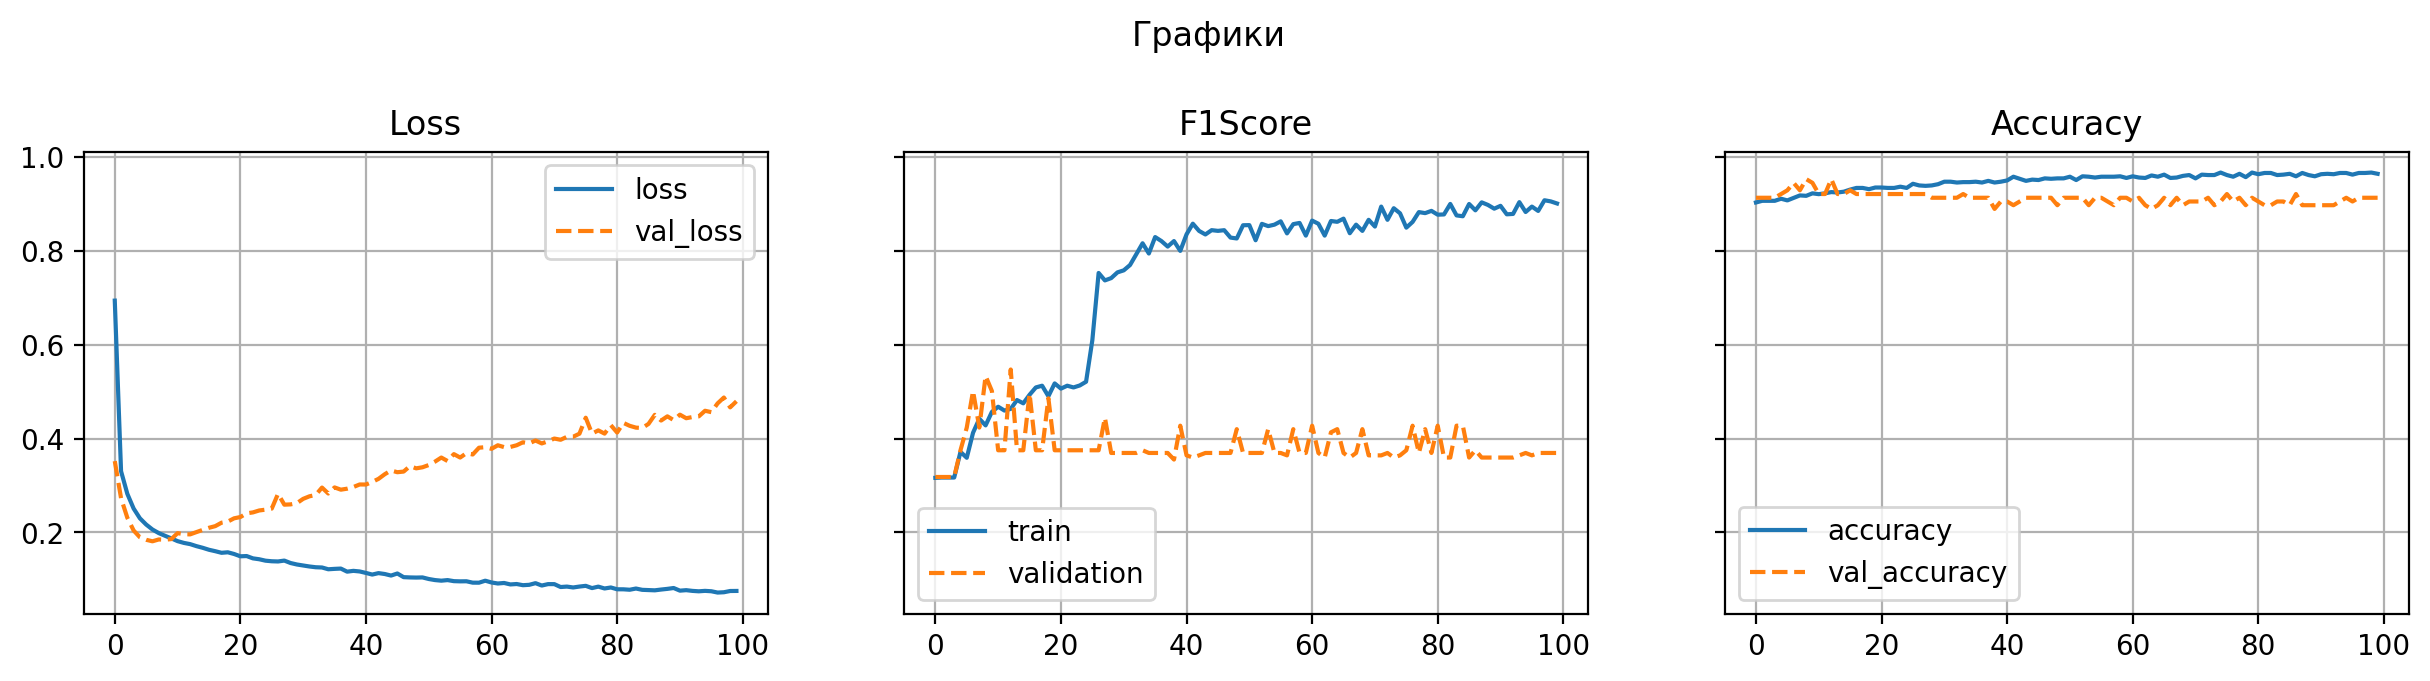

In [ ]:
visualization(history_1)

40/40 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.94      0.97      0.96       295
ограниченно годен       0.17      0.12      0.14        17
         не годен       0.00      0.00      0.00         3

         accuracy                           0.91       315
        macro avg       0.37      0.36      0.36       315
     weighted avg       0.89      0.91      0.90       315



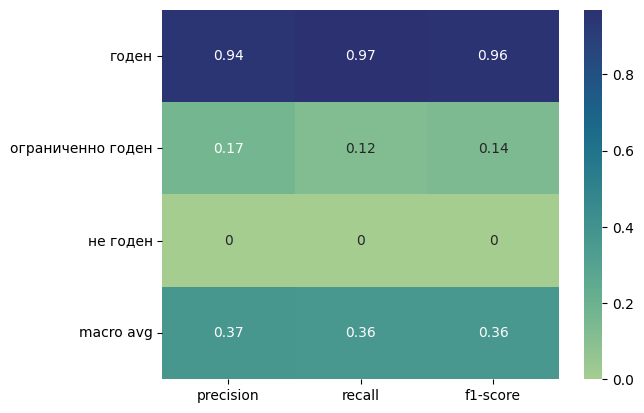

In [ ]:
class_report(model_1)


1.   Виден сильный эффект переобучения сети
2.   Параметр "не годен" не определяется сетью, "ограниченно годен" в очень малом %
> Выводы: необходимо принятие мер по снижению эффекта переобучения и балансировке датасета










---



### 06_2 Эксперимент №2 - 3 Dense слоя + слои нормализации BatchNormalization


> Количество нейронов оставляем аналогично предыдущей сети для дальнейшего сравнения результатов


In [ ]:
model_2 = Sequential()
model_2.add(Dense(16, activation = 'relu', input_shape=(x_train_dataset.shape[1],)))
model_2.add(BatchNormalization())
model_2.add(Dense(32, activation = 'relu'))
model_2.add(BatchNormalization())
model_2.add(Dense( 3, activation = 'softmax'))

# model_2.summary()

model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[metrics_1])

In [ ]:
history_2 = model_2.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
71/71 [==============================] - 3s 16ms/step - loss: 1.0546 - f1_score: 0.3368 - accuracy: 0.5673 - val_loss: 0.7074 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 2/100
71/71 [==============================] - 1s 10ms/step - loss: 0.6030 - f1_score: 0.4785 - accuracy: 0.8372 - val_loss: 0.4926 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 3/100
71/71 [==============================] - 1s 12ms/step - loss: 0.3926 - f1_score: 0.5714 - accuracy: 0.8982 - val_loss: 0.3868 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 4/100
71/71 [==============================] - 1s 11ms/step - loss: 0.2855 - f1_score: 0.6553 - accuracy: 0.9177 - val_loss: 0.3354 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 5/100
71/71 [==============================] - 1s 11ms/step - loss: 0.2382 - f1_score: 0.6506 - accuracy: 0.9186 - val_loss: 0.3064 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 6/100
71/71 [==============================] - 1s 11ms/step - loss: 0.2112

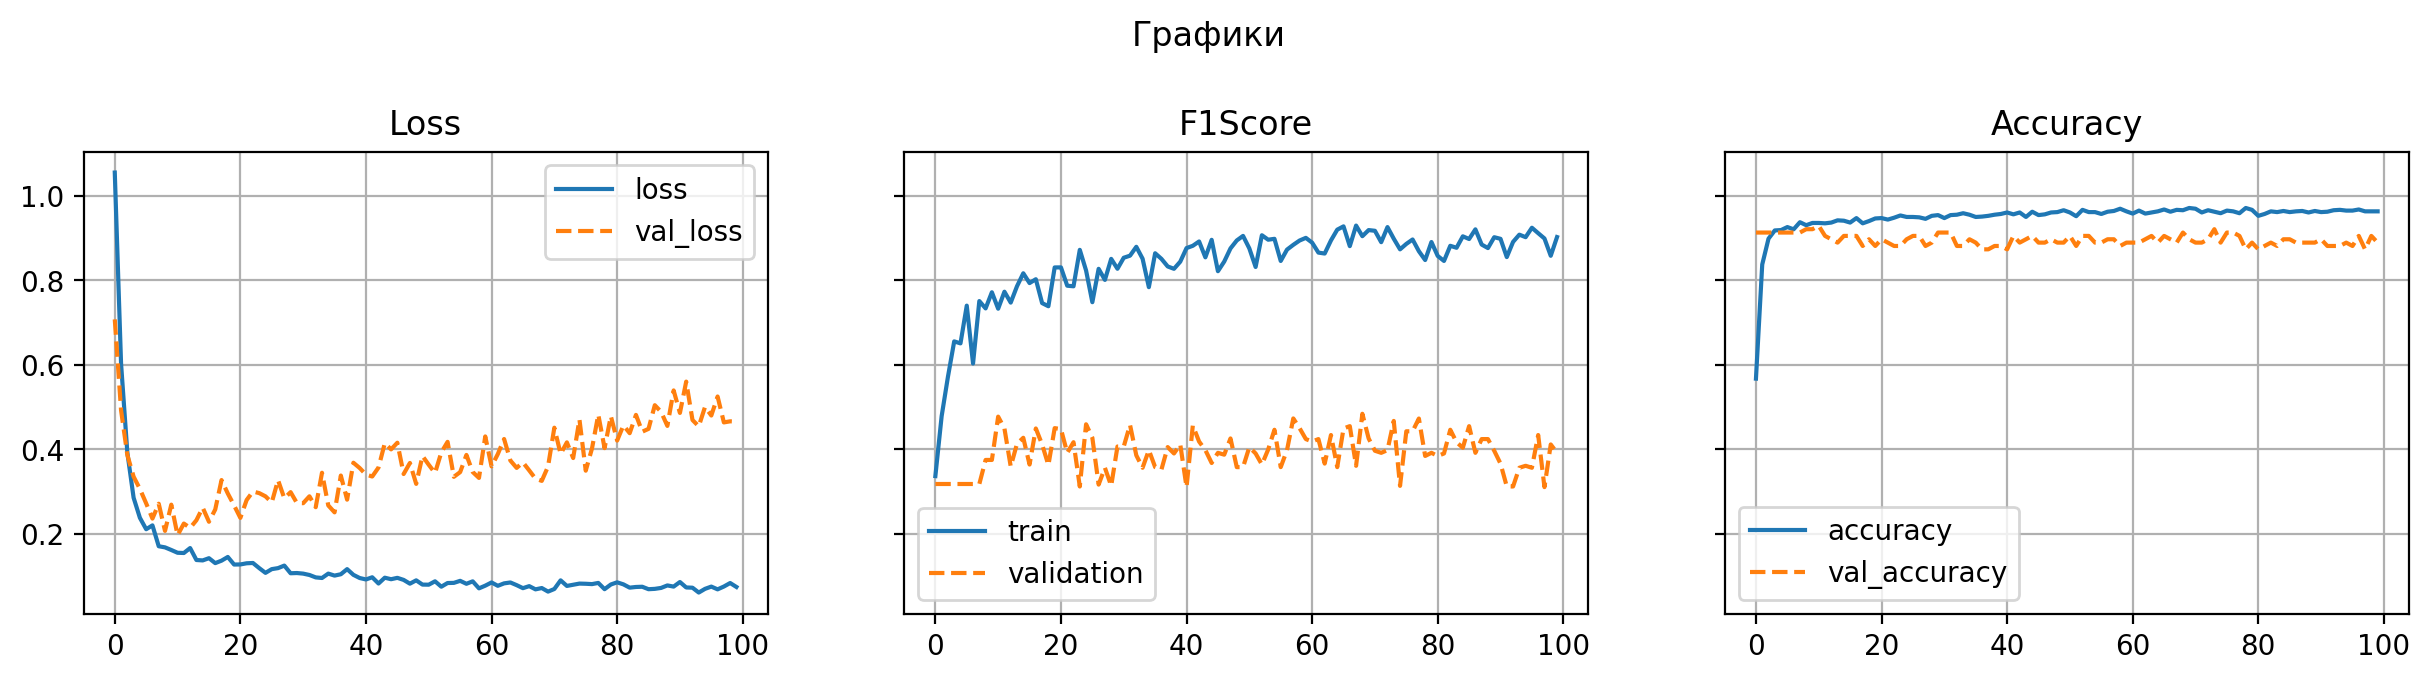

40/40 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.95      0.94      0.94       295
ограниченно годен       0.15      0.18      0.16        17
         не годен       0.00      0.00      0.00         3

         accuracy                           0.89       315
        macro avg       0.37      0.37      0.37       315
     weighted avg       0.89      0.89      0.89       315



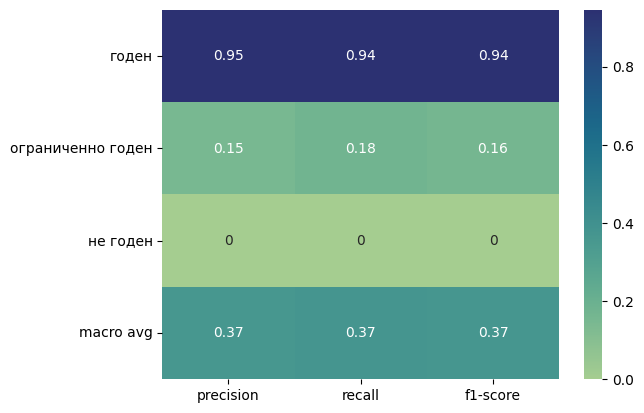

In [ ]:
visualization(history_2)
class_report(model_2)


1.   Как и в предыдущем эксперименте присутствует эффект переобучения сети, тоже достаточно сильно выражен
2.   Параметр "не годен" также не определяется сетью, "ограниченно годен" в очень малом %
> Выводы: слоев BatchNormalization недостаточно необходимо принятие мер по снижению эффекта переобучения и балансировке датасета




---



### 06_3 Эксперимент №3 - 3 Dense слоя + слои нормализации Dropout() + BatchNormalization()

> Количество нейронов оставляем аналогично предыдущей сети для дальнейшего сравнения результатов

In [ ]:
model_3 = Sequential()

model_3.add(Dense(16, activation = 'relu', input_shape=(x_train_dataset.shape[1],)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Dense(32, activation = 'relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Dense( 3, activation = 'softmax'))

# model_3.summary()

model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[metrics_1])

In [ ]:
history_3 = model_3.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
71/71 [==============================] - 2s 11ms/step - loss: 1.3316 - f1_score: 0.2860 - accuracy: 0.4230 - val_loss: 0.8632 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 2/100
71/71 [==============================] - 1s 7ms/step - loss: 0.8999 - f1_score: 0.3151 - accuracy: 0.5912 - val_loss: 0.6911 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 3/100
71/71 [==============================] - 0s 7ms/step - loss: 0.6689 - f1_score: 0.3710 - accuracy: 0.7504 - val_loss: 0.5465 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 4/100
71/71 [==============================] - 0s 7ms/step - loss: 0.5300 - f1_score: 0.4192 - accuracy: 0.8257 - val_loss: 0.4352 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 5/100
71/71 [==============================] - 0s 7ms/step - loss: 0.4390 - f1_score: 0.4247 - accuracy: 0.8726 - val_loss: 0.3464 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 6/100
71/71 [==============================] - 1s 7ms/step - loss: 0.3841 - f1

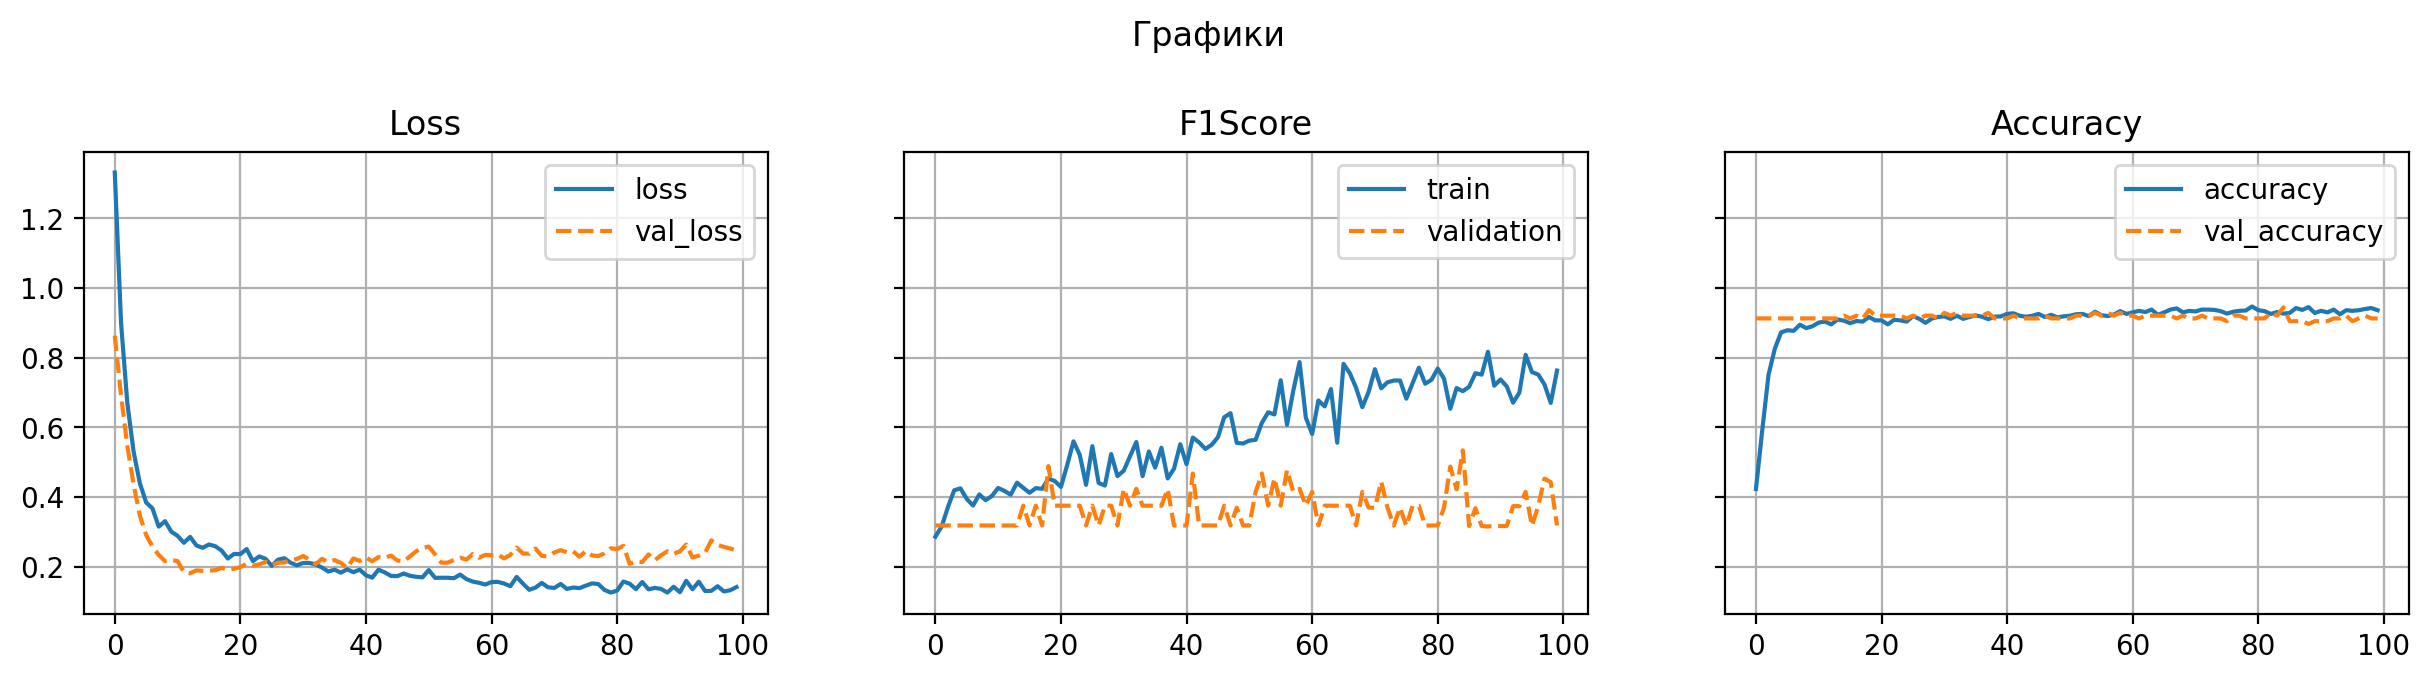

40/40 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.94      0.98      0.96       295
ограниченно годен       0.12      0.06      0.08        17
         не годен       0.00      0.00      0.00         3

         accuracy                           0.92       315
        macro avg       0.35      0.35      0.35       315
     weighted avg       0.89      0.92      0.90       315



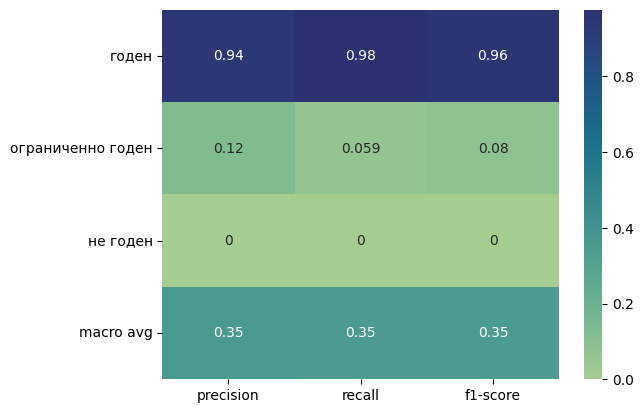

In [ ]:
visualization(history_3)
class_report(model_3)

1.   Получилось снизить эффект переобучения, но все же он присутствует
2.   Параметр "не годен" также не определяется сетью, "ограниченно годен" % обнаружения снизился по сравнению с предыдущими экспериментами
> Выводы: необходимо принятие дополнительных мер по балансировке датасета






---



### 06_4 Эксперимент №4 - 4(!) Dense слоя + слои нормализации Dropout() + BatchNormalization()


In [ ]:
model_4 = Sequential()
model_4.add(Dense(16, activation = 'relu', input_shape=(x_train_dataset.shape[1],)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Dense(32, activation = 'relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Dense(64, activation = 'relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Dense( 3, activation = 'softmax'))

# model_4.summary()

model_4.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[metrics_1])

In [ ]:
history_4 = model_4.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
71/71 [==============================] - 4s 20ms/step - loss: 1.3501 - f1_score: 0.2751 - accuracy: 0.4080 - val_loss: 0.7855 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 2/100
71/71 [==============================] - 1s 12ms/step - loss: 0.8544 - f1_score: 0.3435 - accuracy: 0.6336 - val_loss: 0.4774 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 3/100
71/71 [==============================] - 1s 13ms/step - loss: 0.6334 - f1_score: 0.3656 - accuracy: 0.7726 - val_loss: 0.3693 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 4/100
71/71 [==============================] - 1s 13ms/step - loss: 0.4692 - f1_score: 0.3942 - accuracy: 0.8469 - val_loss: 0.3348 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 5/100
71/71 [==============================] - 1s 14ms/step - loss: 0.4125 - f1_score: 0.3936 - accuracy: 0.8779 - val_loss: 0.3131 - val_f1_score: 0.3181 - val_accuracy: 0.9127
Epoch 6/100
71/71 [==============================] - 1s 14ms/step - loss: 0.3744

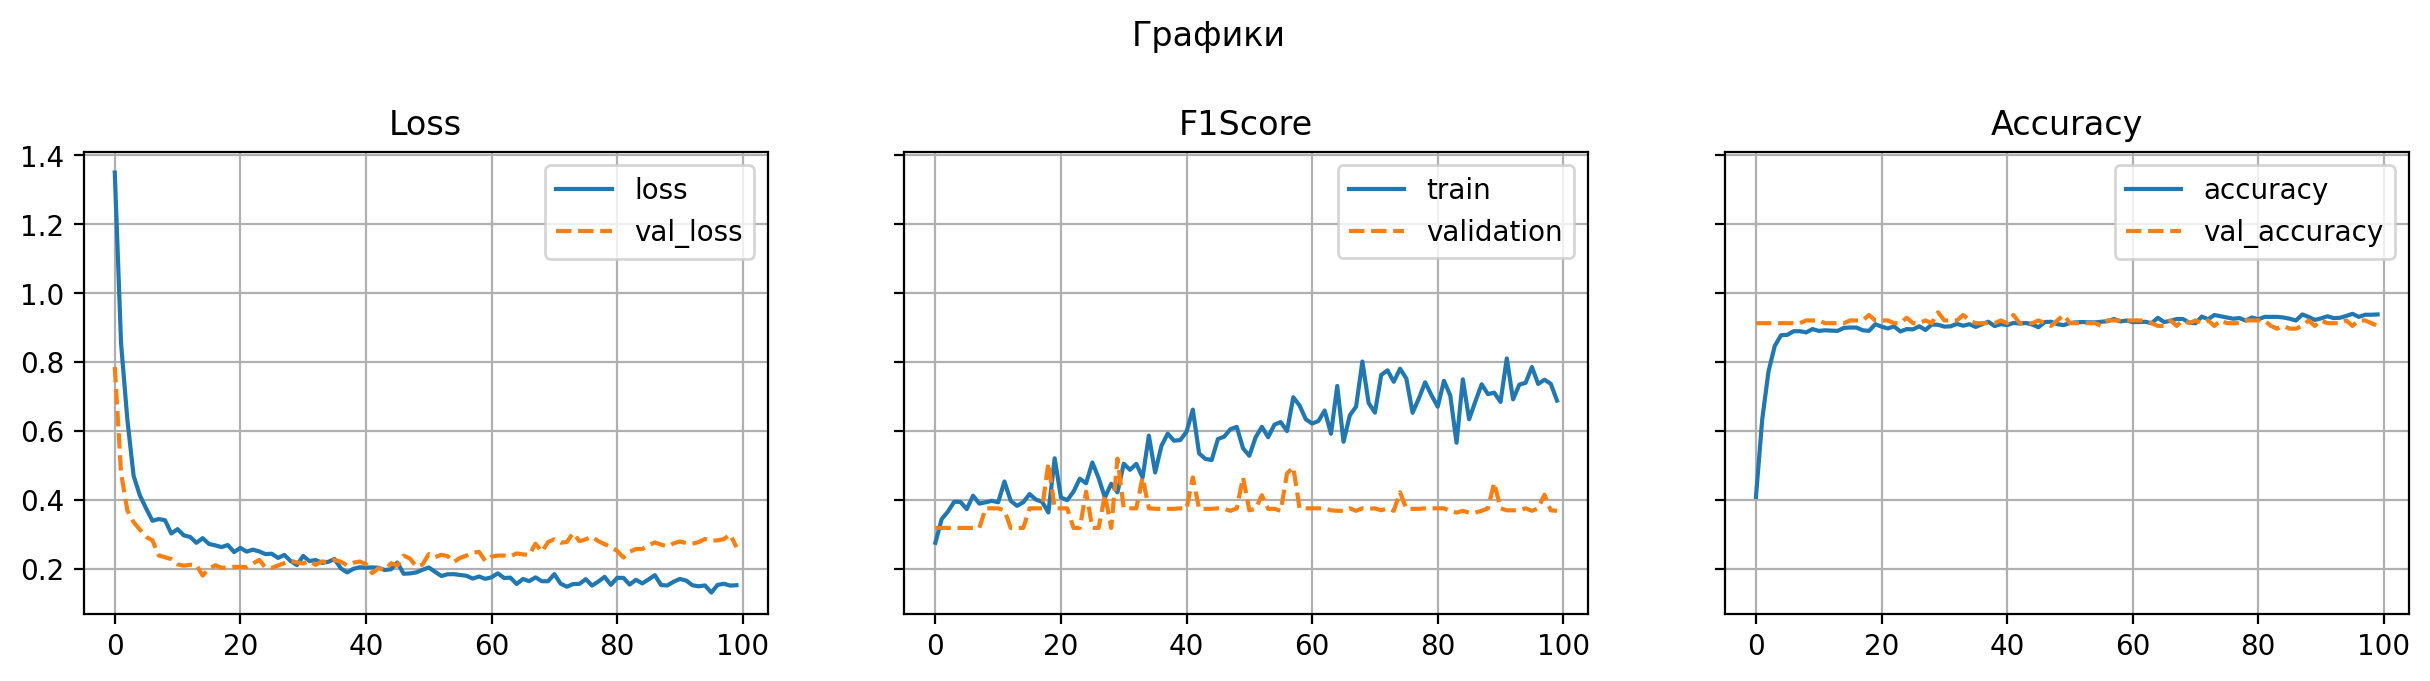

40/40 [==============================] - 0s 3ms/step
                   precision    recall  f1-score   support

            годен       0.95      0.98      0.96       295
ограниченно годен       0.30      0.18      0.22        17
         не годен       0.00      0.00      0.00         3

         accuracy                           0.92       315
        macro avg       0.42      0.38      0.39       315
     weighted avg       0.90      0.92      0.91       315



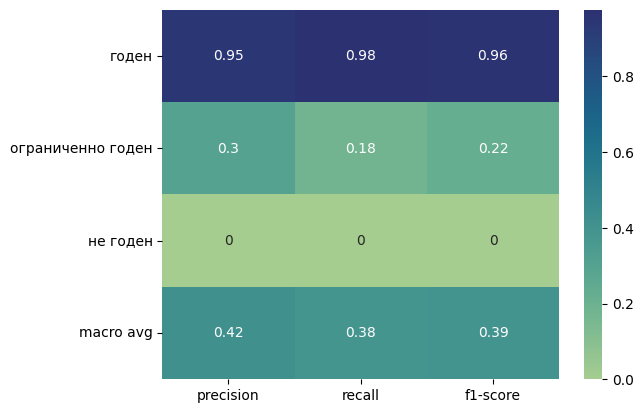

In [ ]:
visualization(history_4)
class_report(model_4)

1.   Получилось снизить эффект переобучения, но все же он присутствует
2.   Параметр "не годен" также не определяется сетью, "ограниченно годен" % обнаружения повысился по сравнению с предыдущими экспериментами
> Выводы: также необходимо принятие дополнительных мер по балансировке датасета + данную архитектуру можно взять за основу для дальнейших экспериментов





---



### 06_5 Эксперимент №5 - 4(!) Dense слоя + слои нормализации Dropout() + BatchNormalization() + увеличение количества эпох и callback для изменения learning rate

In [ ]:
# определяем callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              mode="auto",
                              min_delta=0.00001,
                              cooldown=0,
                              min_lr=1e-5
)

In [ ]:
model_5 = Sequential()
model_5.add(Dense(16, activation = 'relu', input_shape=(x_train_dataset.shape[1],)))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.4))

model_5.add(Dense(32, activation = 'relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.4))

model_5.add(Dense(64, activation = 'relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.4))

model_5.add(Dense(128, activation = 'relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.4))

model_5.add(Dense( 3, activation = 'softmax'))

# model_5.summary()

model_5.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[metrics_1])

In [ ]:
history_5 = model_5.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=500,
                        validation_split=0.1,
                        callbacks=[reduce_lr])

Epoch 1/500
71/71 [==============================] - 5s 21ms/step - loss: 1.3815 - f1_score: 0.2797 - accuracy: 0.4805 - val_loss: 0.5039 - val_f1_score: 0.3181 - val_accuracy: 0.9127 - lr: 0.0010
Epoch 2/500
71/71 [==============================] - 1s 14ms/step - loss: 0.8608 - f1_score: 0.3399 - accuracy: 0.6788 - val_loss: 0.3786 - val_f1_score: 0.3181 - val_accuracy: 0.9127 - lr: 0.0010
Epoch 3/500
71/71 [==============================] - 1s 15ms/step - loss: 0.6319 - f1_score: 0.3789 - accuracy: 0.7929 - val_loss: 0.3437 - val_f1_score: 0.3181 - val_accuracy: 0.9127 - lr: 0.0010
Epoch 4/500
71/71 [==============================] - 1s 14ms/step - loss: 0.5201 - f1_score: 0.3545 - accuracy: 0.8442 - val_loss: 0.3501 - val_f1_score: 0.3181 - val_accuracy: 0.9127 - lr: 0.0010
Epoch 5/500
71/71 [==============================] - 1s 7ms/step - loss: 0.4268 - f1_score: 0.3986 - accuracy: 0.8796 - val_loss: 0.3199 - val_f1_score: 0.3181 - val_accuracy: 0.9127 - lr: 0.0010
Epoch 6/500
68/7

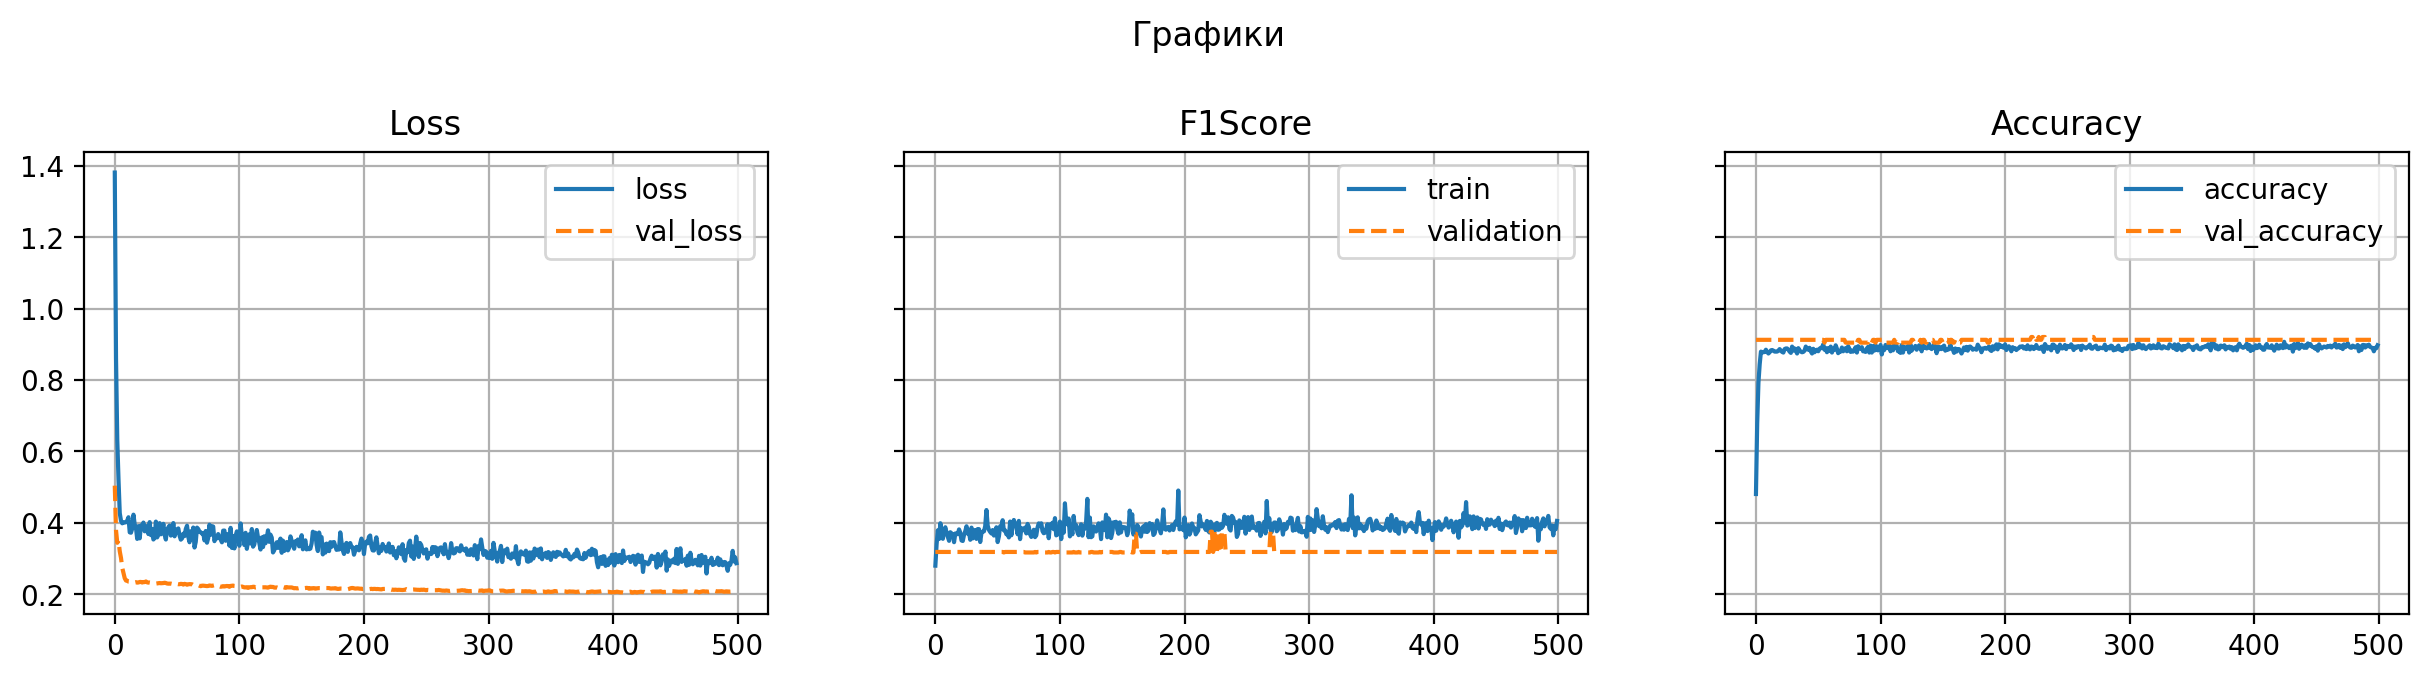

40/40 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.94      1.00      0.97       295
ограниченно годен       0.00      0.00      0.00        17
         не годен       0.00      0.00      0.00         3

         accuracy                           0.94       315
        macro avg       0.31      0.33      0.32       315
     weighted avg       0.88      0.94      0.91       315



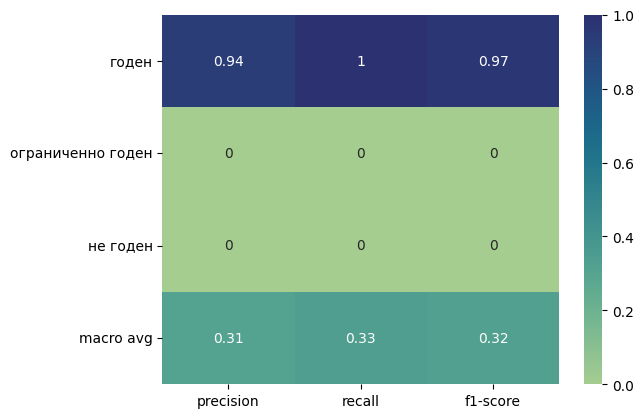

In [ ]:
visualization(history_5)
class_report(model_5)

1.   Эффекта переобучения практически не наблюдается
2.   Результаты отличаются незначительно от предыдущих экспериментов, несмотря на значительное увеличение количества эпох и снижении learning rate
2.   Параметр "не годен" также не определяется сетью, "ограниченно годен" % тоже не обнружен

> Выводы: Настоящий датасет не позволяет добиться поставленной цели, также на предоставленных данных довольно сложно оценить дальнейшее направление работ.



# Общие выводы по проекту

Разбалансированный датасет не позволяет эффективно и корректно настроить нейросеть.

Рекомендации по подготовке датасета:

1. Сложно было работать с дтасетом, где очень много задвоенных данных. Причем данные, которые по логике, должны быть одинаковы могут отличаться. Учитывая данный момент


> Рекомендация 1: совместно с профпатологом, либо на основании к-л методических рекомендаций составить схему данных, которые влияют на принятие решений и сформировать выгрузку только релевантных значений, это значительно сократит время обработки датасета.


2. Данные не сбалансированы. Слишком мало данных для обучения нейросети и по результатам видно, что нейросеть достаточно успешно выделят признак "годен", но насколько она это делает следуя алгоритму (а не просто угадывая) на текущих данных не определить.


> Рекомендация 2: провести балансировку датасета. Возможно следует искуственно расширить данные (для несуществующих пациентов), но расширение датасета следует проводить с консультациями экспертов (врача профпатолога или профильных специалистов)

3. Скорректировать представление в датасете категориальных данных - часто наблюдалось, что категориальные данные либо разделены на несколько колонок, либо вводятся не из справочника, либо друг друга дублируют, либо друг другу противоречат.
Например я бы добавила ряд категориальных данных из заключений профильных специалистов, для проверки гипотезы по их влиянию на результат, но при такой разбалансировке очень сложно будет оценить их влияние.


